In [99]:
# pandas datframe setting
pd.set_option('display.max_columns', None)

In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from datetime import datetime
import calendar
from pandas.api.types import CategoricalDtype
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

## Dataset Creation

In [85]:
customer_data = pd.read_csv('archive/olist_customers_dataset.csv')
geolocation_data = pd.read_csv('archive/olist_geolocation_dataset.csv')
order_items_dataset = pd.read_csv('archive/olist_order_items_dataset.csv')
order_payments_dataset = pd.read_csv('archive/olist_order_payments_dataset.csv')
order_reviews_dataset = pd.read_csv('archive/olist_order_reviews_dataset.csv')
order_dataset = pd.read_csv('archive/olist_orders_dataset.csv')
order_products_dataset = pd.read_csv('archive/olist_products_dataset.csv')
order_sellers_dataset = pd.read_csv('archive/olist_sellers_dataset.csv')
product_translation_dataset = pd.read_csv('archive/product_category_name_translation.csv')

In [100]:
order_reviews_dataset = order_reviews_dataset[['order_id','review_score', 'review_comment_message']]
order_review_data = order_reviews_dataset.merge(order_dataset,on='order_id')
order_products_dataset_english = pd.merge(order_products_dataset,product_translation_dataset,on='product_category_name', how='left')
order_products_dataset_english = order_products_dataset_english.drop(labels='product_category_name',axis=1)
order_product_item_dataset = pd.merge(order_items_dataset,order_products_dataset_english,on='product_id')
ordered_product_reviews = pd.merge(order_product_item_dataset,order_review_data,on='order_id')
ordered_product_reviews_payments = pd.merge(ordered_product_reviews,order_payments_dataset,on='order_id')
df_final = pd.merge(ordered_product_reviews_payments,customer_data,on='customer_id')

In [103]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117329 entries, 0 to 117328
Data columns (total 32 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       117329 non-null  object 
 1   order_item_id                  117329 non-null  int64  
 2   product_id                     117329 non-null  object 
 3   seller_id                      117329 non-null  object 
 4   shipping_limit_date            117329 non-null  object 
 5   price                          117329 non-null  float64
 6   freight_value                  117329 non-null  float64
 7   product_name_lenght            115634 non-null  float64
 8   product_description_lenght     115634 non-null  float64
 9   product_photos_qty             115634 non-null  float64
 10  product_weight_g               117309 non-null  float64
 11  product_length_cm              117309 non-null  float64
 12  product_height_cm             

In [104]:
df_final.isnull().sum()

order_id                             0
order_item_id                        0
product_id                           0
seller_id                            0
shipping_limit_date                  0
price                                0
freight_value                        0
product_name_lenght               1695
product_description_lenght        1695
product_photos_qty                1695
product_weight_g                    20
product_length_cm                   20
product_height_cm                   20
product_width_cm                    20
product_category_name_english     1720
review_score                         0
review_comment_message           67650
customer_id                          0
order_status                         0
order_purchase_timestamp             0
order_approved_at                   15
order_delivered_carrier_date      1235
order_delivered_customer_date     2471
order_estimated_delivery_date        0
payment_sequential                   0
payment_type             

The maximum missing values is seen in the order delivery date feature of the data set with around 2% of the total data. For the numerical features with null values we will use median to handle missing value of these columns. For the date column order delivery date and order approve date we will fill the missing value from the corresponfiing estimated delivery date column and order purchase time column. The customer generally does not pay attention to the order_delivered_carrier_date of their order. so, we will drop this column. Also, the categorical product category feature have null values less than 1% of total data so, we will drop those rows having null values.


In [105]:
# Handling missing values
df_final['product_name_lenght'].fillna(df_final['product_name_lenght'].median(),inplace=True)
df_final['product_description_lenght'].fillna(df_final['product_description_lenght'].median(),inplace=True)
df_final['product_photos_qty'].fillna(df_final['product_photos_qty'].median(),inplace=True)
df_final['product_weight_g'].fillna(df_final['product_weight_g'].median(),inplace=True)
df_final['product_length_cm'].fillna(df_final['product_length_cm'].median(),inplace=True)
df_final['product_height_cm'].fillna(df_final['product_height_cm'].median(),inplace=True)
df_final['product_width_cm'].fillna(df_final['product_width_cm'].median(),inplace=True)

In [106]:
#Handling missing values
ids = (df_final[df_final['order_delivered_customer_date'].isnull() == True].index.values)
vals = df_final.iloc[ids]['order_estimated_delivery_date'].values
df_final.loc[ids,'order_delivered_customer_date'] = vals

ids = (df_final[df_final['order_approved_at'].isnull() == True].index.values)
df_final.loc[ids,'order_approved_at'] = df_final.iloc[ids]['order_purchase_timestamp'].values

df_final.drop(labels='order_delivered_carrier_date',axis=1,inplace=True)

In [107]:
df_final['review_comment_message'].fillna('no_review',inplace=True)

In [108]:
df_final = df_final.dropna()

In [111]:
n1=df_final.shape[0]

In [113]:
print('After dropping we still have {:0.1%} of the data'.format(df_final.shape[0]/n1))

After dropping we still have 100.0% of the data


In [114]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115609 entries, 0 to 117328
Data columns (total 31 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       115609 non-null  object 
 1   order_item_id                  115609 non-null  int64  
 2   product_id                     115609 non-null  object 
 3   seller_id                      115609 non-null  object 
 4   shipping_limit_date            115609 non-null  object 
 5   price                          115609 non-null  float64
 6   freight_value                  115609 non-null  float64
 7   product_name_lenght            115609 non-null  float64
 8   product_description_lenght     115609 non-null  float64
 9   product_photos_qty             115609 non-null  float64
 10  product_weight_g               115609 non-null  float64
 11  product_length_cm              115609 non-null  float64
 12  product_height_cm             

## Dataset Analysis

In [115]:
# checking the review score 
df_final.review_score.value_counts()

5    65374
4    21951
1    14546
3     9718
2     4020
Name: review_score, dtype: int64

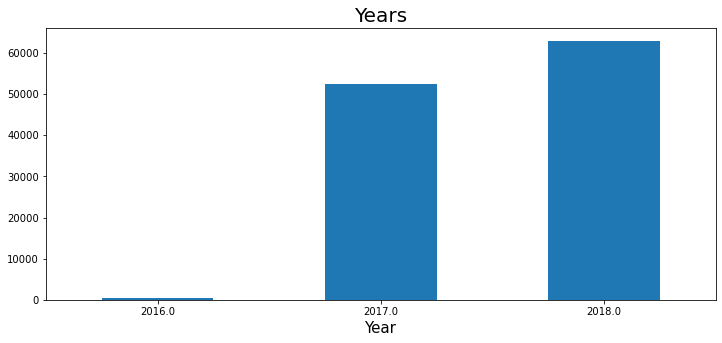

In [91]:
df_final['Year'] = df_final['order_purchase_timestamp'].dt.year
df_final.groupby('Year').size().plot(kind = 'bar',figsize=(12,5));
plt.title('Years',fontsize=20);
plt.xlabel('Year',fontsize=15);
plt.xticks(rotation=0);

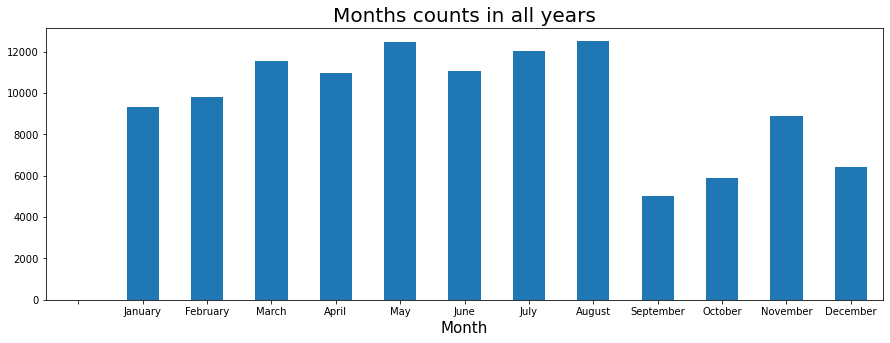

In [92]:
df_final['Month'] =  pd.Series(pd.Categorical(df_final['order_purchase_timestamp'].dt.month_name(), categories=list(calendar.month_name)))
df_final.groupby('Month').size().plot(kind = 'bar',figsize=(15,5))
plt.title('Months counts in all years',fontsize=20);
plt.xlabel('Month',fontsize=15);
plt.xticks(rotation=0);

In [94]:
df_final['Month'] = df_final['order_purchase_timestamp'].dt.month


print('This available data are collected from date {} to date {}'.format(
    df_final.order_purchase_timestamp.min(), df_final.order_purchase_timestamp.max()))
print()
print ('For year 2016 data are for Months {}'.format(sorted(df_final.query('Year==2016').Month.unique())))
print ('For year 2017 data are for Months {}'.format(sorted(df_final.query('Year==2017').Month.unique())))
print ('For year 2018 data are for Months {}'.format(sorted(df_final.query('Year==2018').Month.unique())))

This available data are collected from date 2016-09-04 21:15:19 to date 2018-09-03 09:06:57

For year 2016 data are for Months [9.0, 10.0, 12.0]
For year 2017 data are for Months [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0]
For year 2018 data are for Months [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]


Total orders per year just compares only one month of 2016 with 12 Months of 2017 and 8 Months of 2018 that result in misleading information about trending up of orders.

It was expected November( Black Friday) or December(X-mas) to have the highest value. SO, let's have a deeper lock for the data.



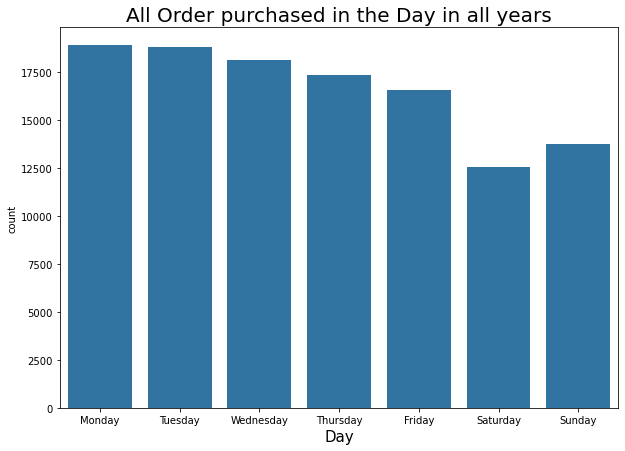

In [95]:
df_final['Day'] = df_final['order_purchase_timestamp'].dt.day_name()

plt.figure(figsize=(10,7))
basecolor=sns.color_palette()[0]
sns.countplot(data=df_final,x='Day',order=list(calendar.day_name),color=basecolor);

plt.title('All Order purchased in the Day in all years', fontsize=20);
plt.xlabel('Day',fontsize=15);

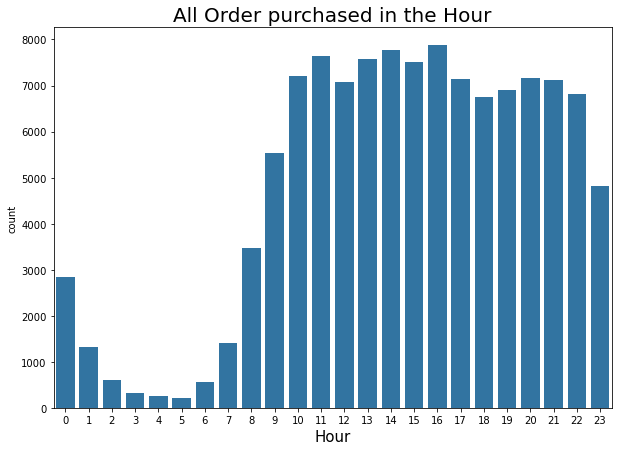

In [96]:
df_final['Hour'] = df_final['order_purchase_timestamp'].dt.hour

plt.figure(figsize=(10,7))
basecolor=sns.color_palette()[0]
sns.countplot(data=df_final ,x='Hour',order=list(range(0, 24)),color=basecolor);

plt.title('All Order purchased in the Hour', fontsize=20);
plt.xlabel('Hour',fontsize=15);

There is no name for the items in the dataset, each item has item_id. Therefore we relate each item by category which belongs to. Below the top 10 popular categories are obtained.

In [97]:
top_10_category = df_final["product_category_name_english"].value_counts().head(10)

print('Top 10 frequently repeated categories')
print('--------------------------------------')
print(top_10_category.reset_index().rename(columns={'index':'product_category',
                                              'product_category_name_english':'counts'}))

Top 10 frequently repeated categories
--------------------------------------
        product_category  counts
0         bed_bath_table   11847
1          health_beauty    9944
2         sports_leisure    8942
3        furniture_decor    8743
4  computers_accessories    8105
5             housewares    7331
6          watches_gifts    6161
7              telephony    4692
8           garden_tools    4558
9                   auto    4356


In [98]:
average_price = df_final.groupby("product_category_name_english")["price"].agg(np.mean).sort_values().tail(10)


print('Top 10 categories with highest average price.')
print('-----------------------------------------------')
print(average_price.sort_values(ascending=False))


Top 10 categories with highest average price.
-----------------------------------------------
product_category_name_english
computers                                1078.555806
small_appliances_home_oven_and_coffee     627.509103
home_appliances_2                         459.567388
agro_industry_and_commerce                332.706151
musical_instruments                       290.755042
small_appliances                          285.925980
fixed_telephony                           227.291004
construction_tools_safety                 211.861162
watches_gifts                             202.204692
air_conditioning                          186.085791
Name: price, dtype: float64


In [ ]:
# https://www.kaggle.com/code/yichengs/brazilian-e-commerce-rating-prediction

In [65]:
# work on correlation

In [66]:
# Covariance measures the directional relationship between the returns on two assets. A positive covariance means that asset returns move together while a negative covariance means they move inversely.

In [68]:
df.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'order_item_id', 'product_id',
       'seller_id', 'shipping_limit_date', 'price', 'freight_value',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'product_category_name_english', 'Year', 'Month', 'Day', 'Hour'],
      dtype='object')

In [73]:
df = df[['order_id', 'customer_id', 'order_item_id', 'product_id', 'order_status', 'order_purchase_timestamp', 'payment_sequential','payment_type', 'payment_installments', 'payment_value', 'customer_zip_code_prefix', 'customer_city', 'customer_state', 'price', 'freight_value', 'product_category_name','product_name_lenght', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'product_category_name_english', 'Year', 'Month', 'Day', 'Hour' ]] 

In [80]:
pd.set_option('display.max_columns', None)

In [81]:
df.head()

,order_id,customer_id,order_item_id,product_id,order_status,order_purchase_timestamp,payment_sequential,payment_type,payment_installments,payment_value,customer_zip_code_prefix,customer_city,customer_state,price,freight_value,product_category_name,product_name_lenght,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,Year,Month,Day,Hour
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,1,87285b34884572647811a353c7ac498a,delivered,2017-10-02 10:56:33,1,credit_card,1,18.12,3149,sao paulo,SP,29.99,8.72,utilidades_domesticas,40.0,500.0,19.0,8.0,13.0,housewares,2017,10,Monday,10
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,1,87285b34884572647811a353c7ac498a,delivered,2017-10-02 10:56:33,3,voucher,1,2.00,3149,sao paulo,SP,29.99,8.72,utilidades_domesticas,40.0,500.0,19.0,8.0,13.0,housewares,2017,10,Monday,10
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,1,87285b34884572647811a353c7ac498a,delivered,2017-10-02 10:56:33,2,voucher,1,18.59,3149,sao paulo,SP,29.99,8.72,utilidades_domesticas,40.0,500.0,19.0,8.0,13.0,housewares,2017,10,Monday,10
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,1,87285b34884572647811a353c7ac498a,delivered,2017-08-15 18:29:31,1,credit_card,3,37.77,3366,sao paulo,SP,29.99,7.78,utilidades_domesticas,40.0,500.0,19.0,8.0,13.0,housewares,2017,8,Tuesday,18
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,1,87285b34884572647811a353c7ac498a,delivered,2017-08-02 18:24:47,1,credit_card,1,37.77,2290,sao paulo,SP,29.99,7.78,utilidades_domesticas,40.0,500.0,19.0,8.0,13.0,housewares,2017,8,Wednesday,18


## 3.4 Feature Engineering

    Sellers Count:- Number of sellers for each product as a feature.
    Products count:- Number of products ordered in each order as a feature.
    Estimated Delivery Time(in number of days):- Gets the days between order approval and estimated delivery date. A customer might be unsatisfied if he is told that the estimated time is big.
    Actual Delivery Time:- Gets the days between order approval and delivered customer date. A customer might be more satisfied if he gets the product faster.
    Difference in delivery days:- The difference between the actual and estimated date. If negative was delivered early, if positive was delivered late. A customer might be more satisfied if the order arrives sooner than expected, or unhappy if he receives after the deadline
    Is Late:- Binary variable indicating if the order was delivered after the estimated date.
    Average Product Value:- Cheaper products might have lower quality, leaving customers unhappy.
    Total Order Value:- If a customer expends more, he might expect a better order fulfilment.
    Order Freight Ratio:- If a customer pays more for freight, he might expect a better service.
    Purchase Day of Week:- Day of week on which purchase was made.
    is_reviewed:- If the review comment is given or not.

In [117]:
# Finding number of sellers for each product as a feature
product_id = order_product_item_dataset.groupby('product_id').count()['seller_id'].index
seller_count = order_product_item_dataset.groupby('product_id').count()['seller_id'].values
product_seller_count = pd.DataFrame({'product_id':product_id,'sellers_count':seller_count})
product_seller_count.head(2)

,product_id,sellers_count
0,00066f42aeeb9f3007548bb9d3f33c38,1
1,00088930e925c41fd95ebfe695fd2655,1


In [118]:
# Finding number of products ordered in each order as a feature
order_id = order_product_item_dataset.groupby('order_id').count()['product_id'].index
pd_count = order_product_item_dataset.groupby('order_id').count()['product_id'].values
order_items_count = pd.DataFrame({'order_id':order_id,'products_count':pd_count})
order_items_count.head(2)

,order_id,products_count
0,00010242fe8c5a6d1ba2dd792cb16214,1
1,00018f77f2f0320c557190d7a144bdd3,1


In [119]:
# Adding the seller count and products count feature to the final data set
df_final = pd.merge(df_final,product_seller_count,on='product_id')
df_final = pd.merge(df_final,order_items_count,on='order_id')

In [120]:
# converting date to datetime and extracting dates from the datetime columns in the data set
datetime_cols = ['order_purchase_timestamp','order_approved_at','order_delivered_customer_date','order_estimated_delivery_date']
for col in datetime_cols:
    df_final[col] = pd.to_datetime(df_final[col]).dt.date

In [128]:
# calculating estimated delivery time
df_final['estimated_delivery_time'] = (df_final['order_estimated_delivery_date'] - df_final['order_approved_at']).dt.days

# calculating actual delivery time
df_final['actual_delivery_time'] = (df_final['order_delivered_customer_date'] - df_final['order_approved_at']).dt.days

# calculating diff_in_delivery_time
df_final['diff_in_delivery_time'] = df_final['estimated_delivery_time'] - df_final['actual_delivery_time']

# finding if delivery was late
df_final['on_time_delivery'] = df_final['order_delivered_customer_date'] < df_final['order_estimated_delivery_date']
df_final['on_time_delivery'] = df_final['on_time_delivery'].astype('int')

# calculating mean product value
df_final['avg_product_value'] = df_final['price']/df_final['products_count']

# finding total order cost
df_final['total_order_cost'] = df_final['price'] + df_final['freight_value']

# calculating order freight ratio
df_final['order_freight_ratio'] = df_final['freight_value']/df_final['price']

# finding the day of week on which order was made
df_final['purchase_dayofweek'] = pd.to_datetime(df_final['order_purchase_timestamp']).dt.dayofweek

# finding the day of month on which order was made
df_final['purchase_dayofmonth'] = pd.to_datetime(df_final['order_purchase_timestamp']).dt.day

# finding the week of month on which order was made
df_final['purchase_weekofmonth'] = df_final['purchase_dayofmonth']//7

# finding the week year on which order was made
df_final['purchase_weekofyear'] = pd.to_datetime(df_final['order_purchase_timestamp']).dt.isocalendar().week

# adding is_reviewed where 1 is if review comment is given otherwise 0.
df_final['is_reviewed'] = (df_final['review_comment_message'] != 'no_review').astype('int')

## Dropping date columns and id columns like seller_id, order_id etc.

In [130]:
df_final.drop(columns=['order_item_id', 'seller_id','shipping_limit_date',
                       'order_purchase_timestamp', 'order_approved_at', 'customer_unique_id'], axis=1,inplace=True)

In [131]:
df_final.head()

,order_id,product_id,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,review_score,review_comment_message,customer_id,order_status,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,customer_zip_code_prefix,customer_city,customer_state,sellers_count,products_count,estimated_delivery_time,actual_delivery_time,diff_in_delivery_time,on_time_delivery,avg_product_value,total_order_cost,order_freight_ratio,purchase_dayofweek,purchase_weekofyear,is_reviewed,purchase_dayofmonth,purchase_weekofmonth
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,58.9,13.29,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff,5,"Perfeito, produto entregue antes do combinado.",3ce436f183e68e07877b285a838db11a,delivered,2017-09-20,2017-09-29,1,credit_card,2,72.19,28013,campos dos goytacazes,RJ,9,1,16,7,9,1,58.9,72.19,0.225637,2,37,1,13,1
1,130898c0987d1801452a8ed92a670612,4244733e06e7ecb4970a6e2683c13e61,55.9,17.96,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff,5,"lannister como sempre, entregou certinho e den...",e6eecc5a77de221464d1c4eaff0a9b64,delivered,2017-07-13,2017-07-26,1,boleto,1,73.86,75800,jatai,GO,9,1,27,14,13,1,55.9,73.86,0.321288,2,26,1,28,4
2,532ed5e14e24ae1f0d735b91524b98b9,4244733e06e7ecb4970a6e2683c13e61,64.9,18.33,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff,4,carrinho muito bonito,4ef55bf80f711b372afebcb7c715344a,delivered,2018-06-04,2018-06-07,1,credit_card,2,83.23,30720,belo horizonte,MG,9,1,20,17,3,1,64.9,83.23,0.282435,4,20,1,18,2
3,6f8c31653edb8c83e1a739408b5ff750,4244733e06e7ecb4970a6e2683c13e61,58.9,16.17,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff,5,no_review,30407a72ad8b3f4df4d15369126b20c9,delivered,2017-08-09,2017-08-25,1,credit_card,3,75.07,83070,sao jose dos pinhais,PR,9,1,24,8,16,1,58.9,75.07,0.274533,1,31,0,1,0
4,7d19f4ef4d04461989632411b7e588b9,4244733e06e7ecb4970a6e2683c13e61,58.9,13.29,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff,5,no_review,91a792fef70ecd8cc69d3c7feb3d12da,delivered,2017-08-24,2017-09-01,1,credit_card,4,72.19,36400,conselheiro lafaiete,MG,9,1,22,14,8,1,58.9,72.19,0.225637,3,32,0,10,1


## Numerical data impute

In [132]:
# numerical features
num_feat = ['price', 'freight_value', 'product_name_lenght','product_description_lenght', 'product_photos_qty',
           'product_weight_g','product_length_cm', 'product_height_cm', 'product_width_cm','sellers_count', 
           'products_count', 'payment_sequential','payment_installments', 'payment_value','on_time_delivery', 
           'estimated_delivery_time','actual_delivery_time', 'diff_in_delivery_time','avg_product_value', 'purchase_dayofweek',
           'total_order_cost', 'order_freight_ratio','is_reviewed']

# categorical features
cat_feat = ['review_comment_message','product_category_name_english','order_status', 'payment_type']

In [133]:
# add median value
from sklearn.impute import SimpleImputer
si = SimpleImputer(strategy='median')
si.fit(df_final[num_feat])
df_final[num_feat] = si.transform(df_final[num_feat])

In [135]:
# Encoding categorical variable
df_final['payment_type'] = df_final['payment_type'].replace({'credit_card':1,'boleto':2,'voucher':3,'debit_card':4})

In [154]:
# one hot encoding of delivery status
vect = CountVectorizer()
vect.fit(df_final['order_status'])

df_final['order_status_vectorized'] = vect.transform(df_final['order_status'])

In [ ]:
# TODO : fix this 

## Encoding numerical features using Normalization

In [158]:
# TODO :

In [159]:
df_final.head(5)

,order_id,product_id,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,review_score,review_comment_message,customer_id,order_status,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,customer_zip_code_prefix,customer_city,customer_state,sellers_count,products_count,estimated_delivery_time,actual_delivery_time,diff_in_delivery_time,on_time_delivery,avg_product_value,total_order_cost,order_freight_ratio,purchase_dayofweek,purchase_weekofyear,is_reviewed,purchase_dayofmonth,purchase_weekofmonth,order_status_vectorized
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,58.9,13.29,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff,5,"Perfeito, produto entregue antes do combinado.",3ce436f183e68e07877b285a838db11a,delivered,2017-09-20,2017-09-29,1.0,1,2.0,72.19,28013,campos dos goytacazes,RJ,9.0,1.0,16.0,7.0,9.0,1.0,58.9,72.19,0.225637,2.0,37,1.0,13,1,"(0, 2)\t1\n (1, 2)\t1\n (2, 2)\t1\n (3, 2..."
1,130898c0987d1801452a8ed92a670612,4244733e06e7ecb4970a6e2683c13e61,55.9,17.96,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff,5,"lannister como sempre, entregou certinho e den...",e6eecc5a77de221464d1c4eaff0a9b64,delivered,2017-07-13,2017-07-26,1.0,2,1.0,73.86,75800,jatai,GO,9.0,1.0,27.0,14.0,13.0,1.0,55.9,73.86,0.321288,2.0,26,1.0,28,4,"(0, 2)\t1\n (1, 2)\t1\n (2, 2)\t1\n (3, 2..."
2,532ed5e14e24ae1f0d735b91524b98b9,4244733e06e7ecb4970a6e2683c13e61,64.9,18.33,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff,4,carrinho muito bonito,4ef55bf80f711b372afebcb7c715344a,delivered,2018-06-04,2018-06-07,1.0,1,2.0,83.23,30720,belo horizonte,MG,9.0,1.0,20.0,17.0,3.0,1.0,64.9,83.23,0.282435,4.0,20,1.0,18,2,"(0, 2)\t1\n (1, 2)\t1\n (2, 2)\t1\n (3, 2..."
3,6f8c31653edb8c83e1a739408b5ff750,4244733e06e7ecb4970a6e2683c13e61,58.9,16.17,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff,5,no_review,30407a72ad8b3f4df4d15369126b20c9,delivered,2017-08-09,2017-08-25,1.0,1,3.0,75.07,83070,sao jose dos pinhais,PR,9.0,1.0,24.0,8.0,16.0,1.0,58.9,75.07,0.274533,1.0,31,0.0,1,0,"(0, 2)\t1\n (1, 2)\t1\n (2, 2)\t1\n (3, 2..."
4,7d19f4ef4d04461989632411b7e588b9,4244733e06e7ecb4970a6e2683c13e61,58.9,13.29,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff,5,no_review,91a792fef70ecd8cc69d3c7feb3d12da,delivered,2017-08-24,2017-09-01,1.0,1,4.0,72.19,36400,conselheiro lafaiete,MG,9.0,1.0,22.0,14.0,8.0,1.0,58.9,72.19,0.225637,3.0,32,0.0,10,1,"(0, 2)\t1\n (1, 2)\t1\n (2, 2)\t1\n (3, 2..."
